In [45]:
import csv
import glob, os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
import datetime
import matplotlib.colors as colors
import matplotlib.cm as cmx
import scipy.signal
from scipy.stats import mstats

In [2]:
# Import all 769 csv files downloaded from Stockpup.com. 
# Since there is no company label on each of these files, add company label, which will be same as filename, 
# to each row of individual company information.

files = glob.glob(r'*_quarterly_financial_data.csv')

combined=pd.DataFrame()

for i in files:
    df=pd.read_csv(i,parse_dates=True,header=0).assign(Symbol=os.path.basename(i))
    combined=combined.append(df,ignore_index=True)

combined['Quarter end']=pd.to_datetime(combined['Quarter end'],errors='coerce',format='%Y-%m-%d')

print(combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55696 entries, 0 to 55695
Data columns (total 42 columns):
Quarter end                                   55696 non-null datetime64[ns]
Shares                                        55696 non-null int64
Shares split adjusted                         55696 non-null int64
Split factor                                  55696 non-null float64
Assets                                        55696 non-null object
Current Assets                                55696 non-null object
Liabilities                                   55696 non-null object
Current Liabilities                           55696 non-null object
Shareholders equity                           55696 non-null object
Non-controlling interest                      55696 non-null int64
Preferred equity                              55696 non-null int64
Goodwill & intangibles                        55696 non-null int64
Long-term debt                                55696 non-null int64
Reve

In [3]:
# In Symbol column, replace _quarterly_financial_data.csv with empty string so that only company symbol is seen

combined1=combined.copy()

combined1['Symbol']=combined1['Symbol'].str.replace(pat='_quarterly_financial_data.csv',repl='')

print(combined1.head())

  Quarter end    Shares  Shares split adjusted  Split factor      Assets  \
0  2017-06-30  70726804               70726804           1.0  2548130000   
1  2017-03-31  70660116               70660116           1.0  2624484000   
2  2016-12-31  71509646               71509646           1.0  2615736000   
3  2016-09-30  71417558               71417558           1.0  2551390000   
4  2016-06-30  72772614               72772614           1.0  2541447000   

  Current Assets Liabilities Current Liabilities Shareholders equity  \
0           None  1006057000                None          1542073000   
1           None  1124291000                None          1500193000   
2           None  1134138000                None          1481598000   
3           None  1094294000                None          1457096000   
4           None  1081799000                None          1459648000   

   Non-controlling interest  ...    P/E ratio  Cumulative dividends per share  \
0                         0  

In [4]:
# Import secwiki_tickers.csv file. This file was obtained from http://www.quantatrisk.com/tag/stocks/
# This file contains all major stock symbols and the corresponding company name, their industry etc.

secwiki_tickers = pd.read_csv('secwiki_tickers.csv')
del secwiki_tickers['Price']
del secwiki_tickers['Collection']

print(secwiki_tickers)

     Ticker                               Name            Sector  \
0         A          Agilent Technologies Inc.        Healthcare   
1        AA                         Alcoa Inc.   Basic Materials   
2      AAME            Atlantic American Corp.         Financial   
3       AAN                      Aaron's, Inc.          Services   
4      AAON                          AAON Inc.  Industrial Goods   
5       AAP            Advance Auto Parts Inc.          Services   
6       AAT        American Assets Trust, Inc.         Financial   
7      AAPL                         Apple Inc.    Consumer Goods   
8      AAWW  Atlas Air Worldwide Holdings Inc.          Services   
9      ABAX                       Abaxis, Inc.        Healthcare   
10      ABC      AmerisourceBergen Corporation          Services   
11     ABCB                     Ameris Bancorp         Financial   
12     ABCD       Cambium Learning Group, Inc.          Services   
13     ABCO         The Advisory Board Company  

In [5]:
# Join combined and secwiki_tickers dataframes by matching Symbol column in combined 
# with Ticker column in secwiki_tickers 

combined2=combined1.copy()

secwiki_tickers['Symbol'] = secwiki_tickers['Ticker']
combined2=combined2.merge(secwiki_tickers,on='Symbol',how='inner')

del combined2['Ticker']

print(combined2.head())

  Quarter end    Shares  Shares split adjusted  Split factor      Assets  \
0  2017-06-30  70726804               70726804           1.0  2548130000   
1  2017-03-31  70660116               70660116           1.0  2624484000   
2  2016-12-31  71509646               71509646           1.0  2615736000   
3  2016-09-30  71417558               71417558           1.0  2551390000   
4  2016-06-30  72772614               72772614           1.0  2541447000   

  Current Assets Liabilities Current Liabilities Shareholders equity  \
0           None  1006057000                None          1542073000   
1           None  1124291000                None          1500193000   
2           None  1134138000                None          1481598000   
3           None  1094294000                None          1457096000   
4           None  1081799000                None          1459648000   

   Non-controlling interest            ...              \
0                         0            ...          

In [6]:
print(combined2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41109 entries, 0 to 41108
Data columns (total 45 columns):
Quarter end                                   41109 non-null datetime64[ns]
Shares                                        41109 non-null int64
Shares split adjusted                         41109 non-null int64
Split factor                                  41109 non-null float64
Assets                                        41109 non-null object
Current Assets                                41109 non-null object
Liabilities                                   41109 non-null object
Current Liabilities                           41109 non-null object
Shareholders equity                           41109 non-null object
Non-controlling interest                      41109 non-null int64
Preferred equity                              41109 non-null int64
Goodwill & intangibles                        41109 non-null int64
Long-term debt                                41109 non-null int64
Reve

In [7]:
# There are too many object dtypes. Many of these are actually numeric. One of them
# is datetime. Convert the required columns.

combined3=combined2.copy()

combined3['Quarter end']=pd.to_datetime(combined3['Quarter end'],errors='coerce',format='%Y-%m-%d')

combined3 = combined3.set_index('Quarter end')

combined3.iloc[:,3:8]=combined3.iloc[:,3:8].apply(pd.to_numeric,errors='coerce')
combined3.iloc[:,12:17]=combined3.iloc[:,12:17].apply(pd.to_numeric,errors='coerce')
combined3.iloc[:,18:23]=combined3.iloc[:,18:23].apply(pd.to_numeric,errors='coerce')
combined3.iloc[:,24:32]=combined3.iloc[:,24:32].apply(pd.to_numeric,errors='coerce')
combined3.iloc[:,33:40]=combined3.iloc[:,33:40].apply(pd.to_numeric,errors='coerce')

print(combined3.info())
print(combined3.index.min())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41109 entries, 2017-06-30 to 2001-09-30
Data columns (total 44 columns):
Shares                                        41109 non-null int64
Shares split adjusted                         41109 non-null int64
Split factor                                  41109 non-null float64
Assets                                        41091 non-null float64
Current Assets                                35392 non-null float64
Liabilities                                   41091 non-null float64
Current Liabilities                           35378 non-null float64
Shareholders equity                           41091 non-null float64
Non-controlling interest                      41109 non-null int64
Preferred equity                              41109 non-null int64
Goodwill & intangibles                        41109 non-null int64
Long-term debt                                41109 non-null int64
Revenue                                       40610 non-nu

In [8]:
# Convert Shares, Shares split adjusted, Assets, Current Assets, Liabilities, Current Liabilities, Shareholders equity
# Non-controlling interest, Preferred equity, Goodwill & intangibles, Long term debt, Revenue, Earnings, Earnings 
# available for common stockholders, Cash from operating activities, Cash from investing activities, Cash from financing 
# activities, Cash change during period, Cash at end of period, Capital expenditures to millions

combined4=combined3.copy()

combined4.iloc[:,0:2]=combined4.iloc[:,0:2]/1000000
combined4.iloc[:,3:15]=combined4.iloc[:,3:15]/1000000
combined4.iloc[:,18:24]=combined4.iloc[:,18:24]/1000000

print(combined4.head())

                Shares  Shares split adjusted  Split factor    Assets  \
Quarter end                                                             
2017-06-30   70.726804              70.726804           1.0  2548.130   
2017-03-31   70.660116              70.660116           1.0  2624.484   
2016-12-31   71.509646              71.509646           1.0  2615.736   
2016-09-30   71.417558              71.417558           1.0  2551.390   
2016-06-30   72.772614              72.772614           1.0  2541.447   

             Current Assets  Liabilities  Current Liabilities  \
Quarter end                                                     
2017-06-30              NaN     1006.057                  NaN   
2017-03-31              NaN     1124.291                  NaN   
2016-12-31              NaN     1134.138                  NaN   
2016-09-30              NaN     1094.294                  NaN   
2016-06-30              NaN     1081.799                  NaN   

             Shareholders equity

In [9]:
# Add a new column called MarketCap, which calculates company`s market capitalization. Multiply shares column by the
# price column to calculate marketcap.

combined5=combined4.copy()

combined5['MarketCap'] = combined5['Shares']*combined5['Price']

print(combined5.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41109 entries, 2017-06-30 to 2001-09-30
Data columns (total 45 columns):
Shares                                        41109 non-null float64
Shares split adjusted                         41109 non-null float64
Split factor                                  41109 non-null float64
Assets                                        41091 non-null float64
Current Assets                                35392 non-null float64
Liabilities                                   41091 non-null float64
Current Liabilities                           35378 non-null float64
Shareholders equity                           41091 non-null float64
Non-controlling interest                      41109 non-null float64
Preferred equity                              41109 non-null float64
Goodwill & intangibles                        41109 non-null float64
Long-term debt                                41109 non-null float64
Revenue                                       

In [10]:
# Currently, we have MarketCap observation for each quarter. 
# For analysis, it will be better to have just one MarketCap observation per company for a given year. 

eda1=combined5.copy()

eda1=eda1['MarketCap'].groupby(eda1['Name']).resample('A').mean()

eda1=pd.DataFrame(eda1)

print(eda1)

                                      MarketCap
Name                 Quarter end               
3M Company           1993-12-31     5843.560924
                     1994-12-31    11001.939184
                     1995-12-31    12252.186644
                     1996-12-31    14468.111127
                     1997-12-31    18803.767501
                     1998-12-31    16661.764375
                     1999-12-31    17375.027511
                     2000-12-31    18426.943576
                     2001-12-31    21243.428357
                     2002-12-31    23081.717686
                     2003-12-31    41081.428744
                     2004-12-31    63823.029223
                     2005-12-31    59424.027301
                     2006-12-31    57495.349060
                     2007-12-31    59875.404692
                     2008-12-31    49477.832617
                     2009-12-31    44072.277528
                     2010-12-31    58913.804908
                     2011-12-31    60711

In [11]:
eda2=eda1.copy()

eda2.reset_index(inplace=True)

print(eda2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10693 entries, 0 to 10692
Data columns (total 3 columns):
Name           10693 non-null object
Quarter end    10693 non-null datetime64[ns]
MarketCap      10630 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 250.7+ KB
None


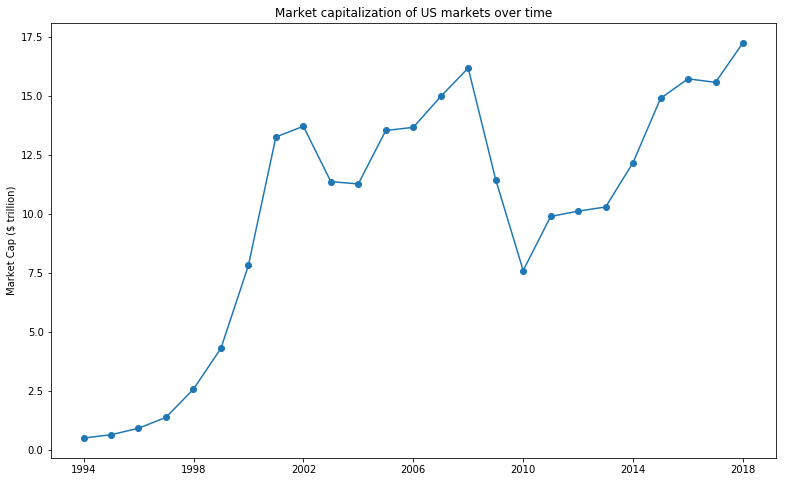

In [12]:
# Plot a graph depicting the total market capitalization of all companies over time

eda3=eda2.copy()

eda3=pd.DataFrame(eda3['MarketCap'].groupby(eda3['Quarter end']).sum())

eda3.reset_index(inplace=True)

eda3['MarketCap($ trillion)']=eda3['MarketCap']/1000000

plt.figure(figsize=(13,8))

plt.plot_date(x="Quarter end",y="MarketCap($ trillion)",data=eda3,linestyle='-')
plt.ylabel('Market Cap ($ trillion)')
plt.title('Market capitalization of US markets over time')
plt.show()

In [13]:
# Plot a graph showing the number of different market cap companies over time. Companies are divided into
# 4 types based on MarketCap: <1B, 1-10B, 10-30B and >30B. 

eda4=eda2.copy()

eda4_1=pd.DataFrame(eda4['MarketCap'][(eda4['MarketCap']<=1000)].groupby(eda4['Quarter end']).count())
eda4_2=pd.DataFrame(eda4['MarketCap'][(eda4['MarketCap']>1000)&(eda4['MarketCap']<=10000)].groupby(eda4['Quarter end']).count())
eda4_3=pd.DataFrame(eda4['MarketCap'][(eda4['MarketCap']>10000)&(eda4['MarketCap']<=30000)].groupby(eda4['Quarter end']).count())
eda4_4=pd.DataFrame(eda4['MarketCap'][eda4['MarketCap']>30000].groupby(eda4['Quarter end']).count())

eda4_1.reset_index(inplace=True)
eda4_2.reset_index(inplace=True)
eda4_3.reset_index(inplace=True)
eda4_4.reset_index(inplace=True)



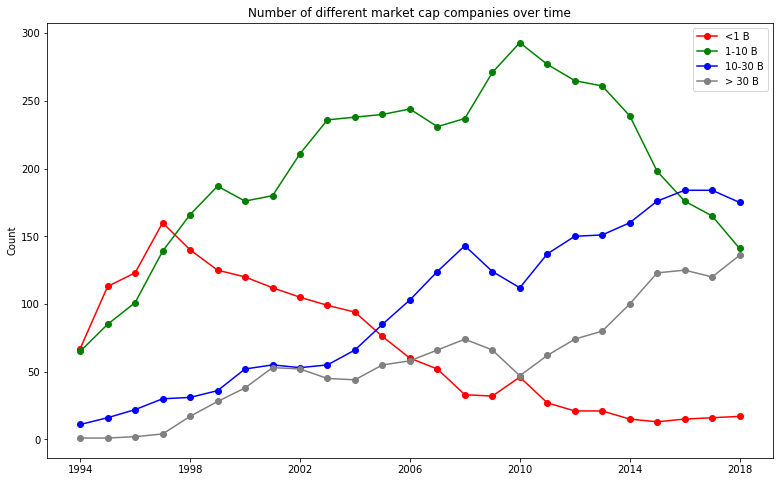

In [14]:
plt.figure(figsize=(13,8))

plt.plot_date(x="Quarter end",y="MarketCap",data=eda4_1,color='red',label='<1 B',linestyle='-')
plt.plot_date(x="Quarter end",y="MarketCap",data=eda4_2,color='green',label='1-10 B',linestyle='-')
plt.plot_date(x="Quarter end",y="MarketCap",data=eda4_3,color='blue',label='10-30 B',linestyle='-')
plt.plot_date(x="Quarter end",y="MarketCap",data=eda4_4,color='grey',label='> 30 B',linestyle='-')

plt.ylabel('Count')
plt.title('Number of different market cap companies over time')
plt.legend()

plt.show()


In [15]:
# Setup a function that adds a new column called Company_Size_Type and assigns each company to 
# the 4 types based on MarketCap

eda5=combined5.copy()

eda5=eda5.loc[:,('MarketCap','P/E ratio')].groupby(eda5['Name']).resample('A').mean()

eda5= eda5.dropna(axis=0)

def company_size(eda5):
    if eda5['MarketCap']<=1000:
        value='< 1 B'
    if (eda5['MarketCap']>1000)&(eda5['MarketCap']<=10000): 
        value='1-10 B'
    if (eda5['MarketCap']>10000)&(eda5['MarketCap']<=30000):
        value='10-30 B'
    if eda5['MarketCap']>30000:
        value='> 30 B'
    return value

eda5['Company_Size_Type'] = eda5.apply(company_size,axis=1)

eda5.reset_index(inplace=True)

print(eda5)

                      Name Quarter end      MarketCap    P/E ratio  \
0               3M Company  1995-12-31   12252.186644    17.790000   
1               3M Company  1996-12-31   14468.111127    29.237500   
2               3M Company  1997-12-31   18803.767501    22.655000   
3               3M Company  1998-12-31   16661.764375    18.370000   
4               3M Company  1999-12-31   17375.027511    27.675000   
5               3M Company  2000-12-31   18426.943576    20.392500   
6               3M Company  2001-12-31   21243.428357    27.395000   
7               3M Company  2002-12-31   23081.717686    29.745000   
8               3M Company  2003-12-31   41081.428744    25.560000   
9               3M Company  2004-12-31   63823.029223    24.620000   
10              3M Company  2005-12-31   59424.027301    20.042500   
11              3M Company  2006-12-31   57495.349060    17.895000   
12              3M Company  2007-12-31   59875.404692    14.810000   
13              3M C

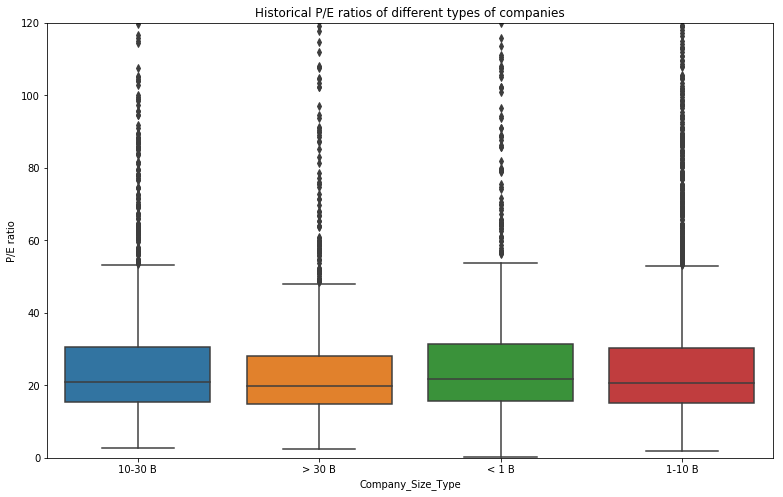

In [27]:
# Plot a boxplot based on different company sizes.

plt.figure(figsize=(13,8))

sns.boxplot(y="P/E ratio",x="Company_Size_Type",data=eda5)

plt.ylim(0,120)

plt.title('Historical P/E ratios of different types of companies')

plt.show()

In [64]:
# Calculate mean P/E ratios of different sized companies over time and plot them

eda6=eda5.copy()

eda6_1 = pd.DataFrame(eda6['P/E ratio'][(eda6['Company_Size_Type']=='< 1 B')].groupby(eda6['Quarter end']).mean())
eda6_2 = pd.DataFrame(eda6['P/E ratio'][(eda6['Company_Size_Type']=='1-10 B')].groupby(eda6['Quarter end']).mean())
eda6_3 = pd.DataFrame(eda6['P/E ratio'][(eda6['Company_Size_Type']=='10-30 B')].groupby(eda6['Quarter end']).mean())
eda6_4 = pd.DataFrame(eda6['P/E ratio'][(eda6['Company_Size_Type']=='> 30 B')].groupby(eda6['Quarter end']).mean())

eda6_1.reset_index(inplace=True)
eda6_2.reset_index(inplace=True)
eda6_3.reset_index(inplace=True)
eda6_4.reset_index(inplace=True)

print(eda6_1)
print(eda6_3)


   Quarter end     P/E ratio
0   1994-12-31  2.031125e+01
1   1995-12-31  2.282441e+01
2   1996-12-31  3.572216e+01
3   1997-12-31  3.921566e+01
4   1998-12-31  5.482008e+01
5   1999-12-31  3.173805e+01
6   2000-12-31  3.003124e+01
7   2001-12-31  2.779865e+01
8   2002-12-31  4.571045e+01
9   2003-12-31  4.238307e+01
10  2004-12-31  1.830344e+16
11  2005-12-31  4.848334e+01
12  2006-12-31  4.928476e+01
13  2007-12-31  4.412348e+01
14  2008-12-31  2.347179e+01
15  2009-12-31  2.404078e+01
16  2010-12-31  2.583483e+01
17  2011-12-31  2.192157e+01
18  2012-12-31  3.328863e+01
19  2013-12-31  3.060269e+01
20  2014-12-31  3.653508e+01
21  2015-12-31  2.842792e+01
22  2016-12-31  3.762646e+01
23  2017-12-31  4.480864e+01
   Quarter end     P/E ratio
0   1995-12-31  2.116116e+01
1   1996-12-31  2.393772e+01
2   1997-12-31  1.860147e+16
3   1998-12-31  3.162674e+01
4   1999-12-31  1.408224e+02
5   2000-12-31  3.454035e+02
6   2001-12-31  4.923893e+01
7   2002-12-31  3.721428e+01
8   2003-12-31

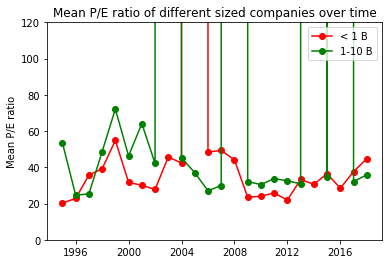

In [88]:
#plt.figure(figsize=(13,18))

plt.plot_date(x="Quarter end",y="P/E ratio",data=eda6_1,color="red",label="< 1 B",linestyle='-')
plt.plot_date(x="Quarter end",y="P/E ratio",data=eda6_2,color="green",label="1-10 B",linestyle='-')

plt.title('Mean P/E ratio of different sized companies over time')
plt.ylabel('Mean P/E ratio')

plt.ylim(0,120)
plt.legend(loc='upper right')

plt.show()


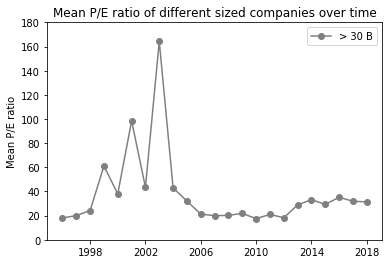

In [92]:
plt.plot_date(x="Quarter end",y="P/E ratio",data=eda6_4,color="grey",label="> 30 B",linestyle='-')

plt.title('Mean P/E ratio of different sized companies over time')
plt.ylabel('Mean P/E ratio')

plt.ylim(0,180)
plt.legend(loc='upper right')

plt.show()

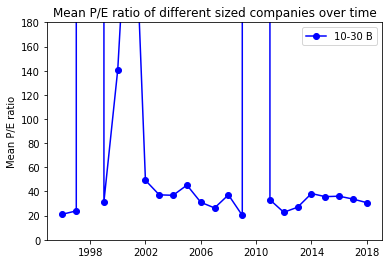

In [91]:
plt.plot_date(x="Quarter end",y="P/E ratio",data=eda6_3,color="blue",label="10-30 B",linestyle='-')
plt.title('Mean P/E ratio of different sized companies over time')
plt.ylabel('Mean P/E ratio')

plt.ylim(0,180)
plt.legend(loc='upper right')

plt.show()

In [18]:
# Calculate scaled value of marketcap and long-term debt. The sum of all scaled markt cap should equal 1.
# Similarly for scaled long term debt. Scaling ensures that the scatter plot between market cap and long term
# debt is within manageable limits. 

eda7=combined5.copy()

eda7['Long-term debt_Scaled']=eda7['Long-term debt']/sum(eda7['Long-term debt'])

eda7=eda7[pd.notnull(eda7['MarketCap'])]

eda7['MarketCap_Scaled']=eda7['MarketCap']/sum(eda7['MarketCap'])

def company_size(eda7):
    if eda7['MarketCap']<=1000:
        value1='< 1 B'
    if (eda7['MarketCap']>1000)&(eda7['MarketCap']<=10000): 
        value1='1-10 B'
    if (eda7['MarketCap']>10000)&(eda7['MarketCap']<=30000):
        value1='10-30 B'
    if eda7['MarketCap']>30000:
        value1='> 30 B'
    return value1

eda7['Company_Size_Type'] = eda7.apply(company_size,axis=1)

#eda7['Company_Size_Type'] = eda7['Company_Size_Type'].astype('category')

eda7.reset_index(inplace=True)

print(eda7.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40844 entries, 0 to 40843
Data columns (total 49 columns):
Quarter end                                   40844 non-null datetime64[ns]
Shares                                        40844 non-null float64
Shares split adjusted                         40844 non-null float64
Split factor                                  40844 non-null float64
Assets                                        40826 non-null float64
Current Assets                                35178 non-null float64
Liabilities                                   40826 non-null float64
Current Liabilities                           35164 non-null float64
Shareholders equity                           40826 non-null float64
Non-controlling interest                      40844 non-null float64
Preferred equity                              40844 non-null float64
Goodwill & intangibles                        40844 non-null float64
Long-term debt                                40844 non-

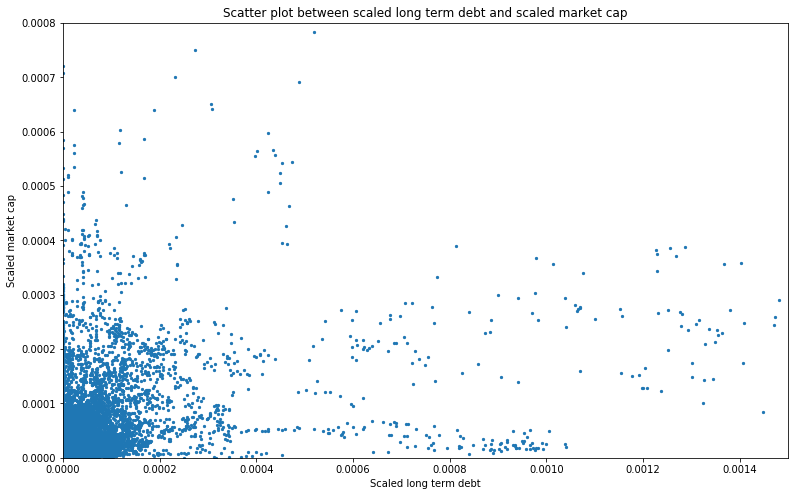

In [19]:
# Scatter plot between scaled market cap and scaled long term debt.

plt.figure(figsize=(13,8))

plt.scatter(y="MarketCap_Scaled",x="Long-term debt_Scaled",data=eda7,s=5)

plt.xlabel('Scaled long term debt')
plt.ylabel('Scaled market cap')

plt.xlim(0,0.0015)
plt.ylim(0,0.0008)
plt.title('Scatter plot between scaled long term debt and scaled market cap')

plt.show()

In [20]:
eda8=combined5.copy()

eda8['MarketCap($ trillion)']=eda8['MarketCap']/1000000

eda8=pd.DataFrame(eda8['MarketCap($ trillion)'].groupby(eda8['Symbol']).resample('A').mean())

eda8.reset_index(inplace=True)

eda8=eda8.merge(secwiki_tickers,on='Symbol',how='inner')

eda8_1=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Basic Materials'].groupby(eda8['Quarter end']).sum())
eda8_2=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Consumer Goods'].groupby(eda8['Quarter end']).sum())
eda8_3=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Financial'].groupby(eda8['Quarter end']).sum())
eda8_4=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Healthcare'].groupby(eda8['Quarter end']).sum())
eda8_5=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Industrial Goods'].groupby(eda8['Quarter end']).sum())
eda8_6=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Services'].groupby(eda8['Quarter end']).sum())
eda8_7=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Technology'].groupby(eda8['Quarter end']).sum())
eda8_8=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Utilities'].groupby(eda8['Quarter end']).sum())

eda8_1.reset_index(inplace=True)
eda8_2.reset_index(inplace=True)
eda8_3.reset_index(inplace=True)
eda8_4.reset_index(inplace=True)
eda8_5.reset_index(inplace=True)
eda8_6.reset_index(inplace=True)
eda8_7.reset_index(inplace=True)
eda8_8.reset_index(inplace=True)

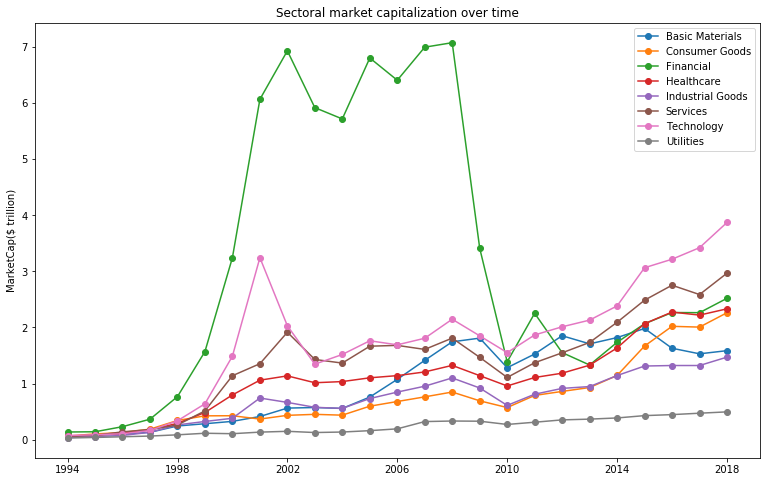

In [21]:
plt.figure(figsize=(13,8))

plt.plot_date(x="Quarter end",y="MarketCap($ trillion)",data=eda8_1,label='Basic Materials',linestyle='-')
plt.plot_date(x="Quarter end",y="MarketCap($ trillion)",data=eda8_2,label='Consumer Goods',linestyle='-')
plt.plot_date(x="Quarter end",y="MarketCap($ trillion)",data=eda8_3,label='Financial',linestyle='-')
plt.plot_date(x="Quarter end",y="MarketCap($ trillion)",data=eda8_4,label='Healthcare',linestyle='-')
plt.plot_date(x="Quarter end",y="MarketCap($ trillion)",data=eda8_5,label='Industrial Goods',linestyle='-')
plt.plot_date(x="Quarter end",y="MarketCap($ trillion)",data=eda8_6,label='Services',linestyle='-')
plt.plot_date(x="Quarter end",y="MarketCap($ trillion)",data=eda8_7,label='Technology',linestyle='-')
plt.plot_date(x="Quarter end",y="MarketCap($ trillion)",data=eda8_8,label='Utilities',linestyle='-')

plt.legend()

plt.ylabel('MarketCap($ trillion)')

plt.title('Sectoral market capitalization over time')

plt.show()


In [93]:
eda9=combined5.copy()

eda9=pd.DataFrame(eda8['P/E ratio'].groupby(eda8['Symbol']).resample('A').mean())

eda8.reset_index(inplace=True)

eda8=eda8.merge(secwiki_tickers,on='Symbol',how='inner')

eda8_1=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Basic Materials'].groupby(eda8['Quarter end']).sum())
eda8_2=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Consumer Goods'].groupby(eda8['Quarter end']).sum())
eda8_3=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Financial'].groupby(eda8['Quarter end']).sum())
eda8_4=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Healthcare'].groupby(eda8['Quarter end']).sum())
eda8_5=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Industrial Goods'].groupby(eda8['Quarter end']).sum())
eda8_6=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Services'].groupby(eda8['Quarter end']).sum())
eda8_7=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Technology'].groupby(eda8['Quarter end']).sum())
eda8_8=pd.DataFrame(eda8['MarketCap($ trillion)'][eda8['Sector']=='Utilities'].groupby(eda8['Quarter end']).sum())

eda8_1.reset_index(inplace=True)
eda8_2.reset_index(inplace=True)
eda8_3.reset_index(inplace=True)
eda8_4.reset_index(inplace=True)
eda8_5.reset_index(inplace=True)
eda8_6.reset_index(inplace=True)
eda8_7.reset_index(inplace=True)
eda8_8.reset_index(inplace=True)

      Symbol Quarter end  MarketCap($ trillion) Ticker  \
0          A  2000-12-31               0.033562      A   
1          A  2001-12-31               0.017445      A   
2          A  2002-12-31               0.011328      A   
3          A  2003-12-31               0.008680      A   
4          A  2004-12-31               0.013619      A   
5          A  2005-12-31               0.011796      A   
6          A  2006-12-31               0.014185      A   
7          A  2007-12-31               0.013559      A   
8          A  2008-12-31               0.011534      A   
9          A  2009-12-31               0.007146      A   
10         A  2010-12-31               0.010758      A   
11         A  2011-12-31               0.014835      A   
12         A  2012-12-31               0.014678      A   
13         A  2013-12-31               0.014977      A   
14         A  2014-12-31               0.018610      A   
15         A  2015-12-31               0.013236      A   
16         A  